In [1]:
from astropy.io import fits #astropy modules for FITS IO
import numpy as np #numpy gives us better array management 
from scipy.optimize import least_squares

In [2]:
import matplotlib  #ploting
matplotlib.use("Agg")  #some hack to stop the bouncing python icon when plotting
import matplotlib.pyplot as plt
#next line is to show plots inline with jupyter
#%matplotlib inline 
from matplotlib.colors import LogNorm #for better display of FITS images

In [3]:
%matplotlib inline

In [4]:
filename="../samples/cube-700-CLR.fits"
hdulist = fits.open(filename) #open the FITS file

In [5]:
hdulist.info() #look at contents

Filename: ../samples/cube-700-CLR.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     438   (256, 2048, 5)   int16 (rescales to uint16)   
1    ENG         BinTableHDU     15   28888R x 3C   [30A, 30A, 30A]   


In [6]:
scidata = hdulist[0].data #extract the Image

In [7]:
print(scidata.shape[0],scidata.shape[1],scidata.shape[2])

5 2048 256


In [7]:
import importlib

In [25]:
importlib.reload(rb)

<module 'robustfit' from '/Users/rowe/Documents/jwst/JWSTNIRISS/ramps2slopes/robustfit.cpython-35m-darwin.so'>

In [8]:
import robustfit as rb

In [9]:
rb.robustfit.__doc__

"robustfit(naxes,imagecube,bpix,sat,zpt,slope,image)\n\nWrapper for ``robustfit``.\n\nParameters\n----------\nnaxes : input rank-1 array('i') with bounds (3)\nimagecube : input rank-3 array('d') with bounds (f2py_imagecube_d0,f2py_imagecube_d1,f2py_imagecube_d2)\nbpix : input float\nsat : input float\nzpt : input rank-2 array('d') with bounds (f2py_zpt_d0,f2py_zpt_d1)\nslope : input rank-2 array('d') with bounds (f2py_slope_d0,f2py_slope_d1)\nimage : input rank-2 array('d') with bounds (f2py_image_d0,f2py_image_d1)\n"

In [10]:
naxes=np.zeros(3,dtype="int32") #store size of image.
naxes[0]=int(scidata.shape[0])
naxes[1]=int(scidata.shape[1])
naxes[2]=int(scidata.shape[2])
bpix=np.float(-1.0e10)
sat=np.float(65535.0)
zpt=np.zeros(shape=(naxes[1],naxes[2]),order='F')
slope=np.zeros(shape=(naxes[1],naxes[2]),order='F')
image=np.zeros(shape=(naxes[1],naxes[2]),order='F')
rb.robustfit(naxes,scidata,bpix,sat,zpt,slope,image)

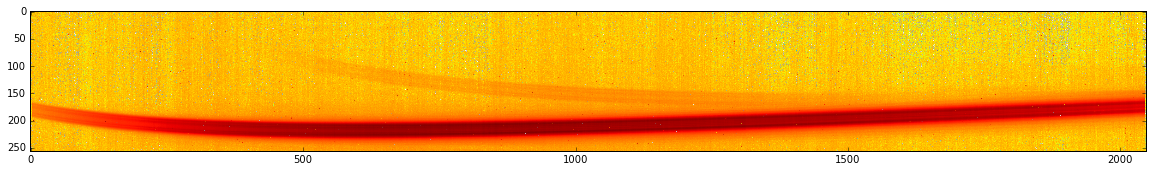

In [12]:
plt.figure(figsize=(20,4)) #adjust size of figure
imgplot = plt.imshow(np.transpose(image),norm=LogNorm())
plt.show()

In [47]:
len(scidata.shape)  #check that we have a data-cube.  This should be 3.

3

In [7]:
print(scidata.shape) #print the shape info.

(5, 2048, 256)


In [38]:
#Function for a straight line
def func_line(x,framenumber):
    f = x[0]+x[1]*framenumber
    return f;

In [39]:
#Returns different between counts and straight line model
def func_diff(x,framenumber,counts):
    f = func_line(x,framenumber)
    diff=f-counts
    return diff;

In [90]:
image_zpoint=np.zeros([scidata.shape[1],scidata.shape[2]]) #zero-point of fit
image_slope=np.zeros([scidata.shape[1],scidata.shape[2]])  #slope of fit
image_fit=np.zeros([scidata.shape[1],scidata.shape[2]])    #modeled counts 

In [92]:
sat=65535.0 #saturation
r = np.linspace(0, 5, 100)
soft_l1 = 2 * (np.sqrt(1 + r**2) - 1) #robust fits

for xpix in range(scidata.shape[1]):
    for ypix in range(scidata.shape[2]):

        framenumber=np.linspace(0,scidata.shape[0]-1,scidata.shape[0])
        counts=scidata[:,xpix,ypix]

        x0=[0,0] #initial guess for parameters
        x0[0]=np.min(counts)
        x0[1]=(np.max(counts)-np.min(counts))/scidata.shape[0]

        res_lsq = least_squares(func_diff, x0, args=(framenumber, counts),loss='soft_l1', f_scale=0.1)
        #print(res_lsq.x)
        
        image_zpoint[xpix,ypix]=res_lsq.x[0]
        image_slope[xpix,ypix]=res_lsq.x[1]
        image_fit[xpix,ypix]=func_line(res_lsq.x,scidata.shape[0])-image_zpoint[xpix,ypix]
        
        #print(image_zpoint[xpix,ypix],image_slope[xpix,ypix],image_fit[xpix,ypix])
        
        #input()

KeyboardInterrupt: 

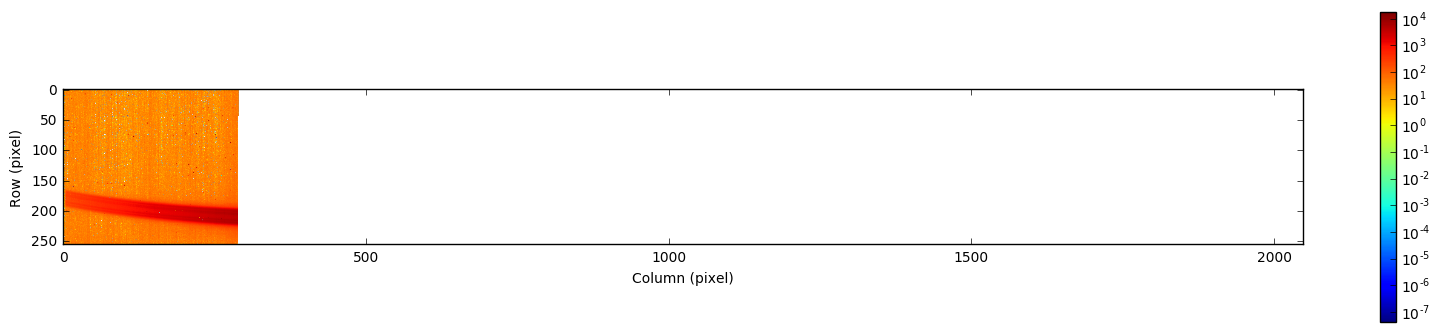

In [93]:
plt.figure(figsize=(20,4)) #adjust size of figure
imgplot = plt.imshow(np.transpose(image_fit),norm=LogNorm()) #added log stretch to the plot
#imgplot = plt.imshow(np.transpose(scidata[4,:,:]),norm=LogNorm()) #added log stretch to the plot
plt.xlabel('Column (pixel)') #x-label
plt.ylabel('Row (pixel)') #y-label
imgplot = plt.colorbar() #add colour bar

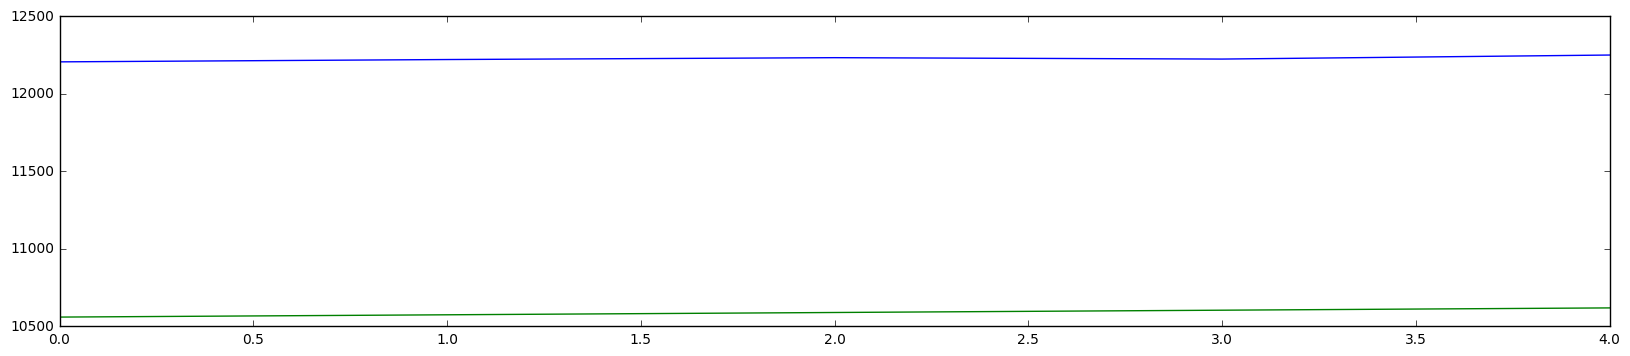

In [91]:
x=res_lsq.x
fn=np.linspace(0,scidata.shape[0]-1,scidata.shape[0])
f=funcline(x,fn)

plt.figure(figsize=(20,4)) #adjust size of figure
plt.plot(fn,scidata[:,xpix,ypix])
plt.plot(fn,f)
plt.show()